<a href="https://colab.research.google.com/github/KacaPopovic/Minimal-GAN/blob/main/GANs_trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [3]:
##load  MNIST
# Samples
Nsamples = 100
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=Nsamples,shuffle=True)

mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=Nsamples, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5077509.78it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134384.23it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 637142.22it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5529906.75it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Define the generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [5]:
# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        logit = self.fc2(x)
        prob = self.sigmoid(logit)
        return logit, prob

In [10]:
# Noise dimensions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
zdim = 50
# Initialize models
G = Generator(zdim, 784).to(device)
D = Discriminator(784).to(device)

# Optimizers
lr = 0.0002
G_opt = torch.optim.Adam(G.parameters(), lr=lr)
D_opt = torch.optim.Adam(D.parameters(), lr=lr)
# Generate samples
def draw_sample(m, n):
    return np.random.uniform(-1.0, 1.0, size=[m, n])

# Loss function
criterion = nn.BCELoss()
num_epochs = int(1e3)
# Samples
Nsamples = 100

# Lists to store losses
D_losses = []
G_losses = []

for epoch in range(num_epochs):
    D_loss_epoch = 0
    G_loss_epoch = 0
    num_batches = 0
    for imgs, _ in mnist_loader_train:
        imgs = imgs.view(-1, 784).to(device)
        batch_size = imgs.size(0)

        z = torch.Tensor(draw_sample(Nsamples, zdim)).to(device)
        real_labels = torch.ones(Nsamples,1).to(device)
        fake_labels = torch.zeros(Nsamples,1).to(device)

        D_real_logit, D_real_prob = D(imgs)
        G_sample = G(z)

        D_fake_logit, D_dake_prob = D(G_sample.detach())

        # 1. Update the discriminator using real and generated samples

        D_loss_real = criterion(D_real_prob, real_labels)
        D_loss_fake = criterion(D_dake_prob, fake_labels)
        D_loss = D_loss_real + D_loss_fake

        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()

        # 2. Update the generator

        G_fake_logit, G_fake_prob = D(G_sample)
        G_loss = criterion(G_fake_prob, real_labels)

        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()
        # Accumulate losses
        D_loss_epoch += D_loss.item()
        G_loss_epoch += G_loss.item()
        num_batches += 1

    # Calculate average losses for the epoch
    D_losses.append(D_loss_epoch / num_batches)
    G_losses.append(G_loss_epoch / num_batches)

    if epoch % int(1e2) == 0:
        print('Epoch {}, Discriminator Loss {:.3f}, Generator Loss {:.3f}'.format(epoch, D_loss_epoch /num_batches, G_loss_epoch/num_batches))

Epoch 0, Discriminator Loss 0.317, Generator Loss 3.143
Epoch 100, Discriminator Loss 0.442, Generator Loss 3.082
Epoch 200, Discriminator Loss 0.789, Generator Loss 1.949
Epoch 300, Discriminator Loss 0.638, Generator Loss 2.253


KeyboardInterrupt: 

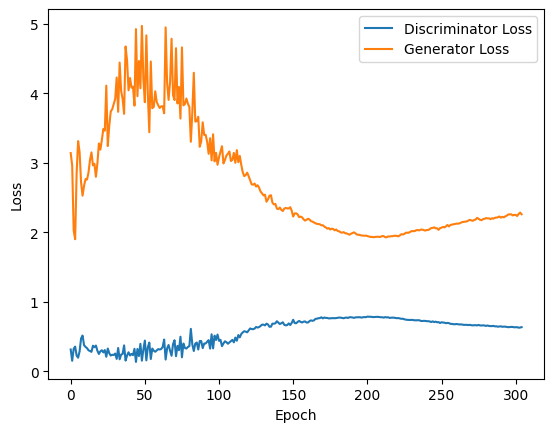

<Figure size 640x480 with 0 Axes>

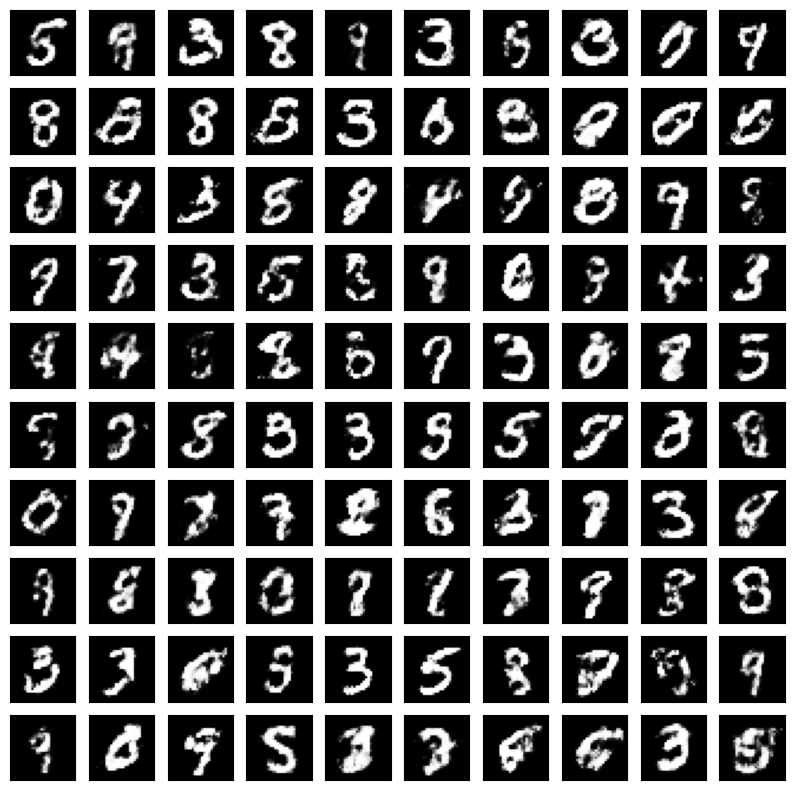

In [11]:
#plot losses and generated images
import os

# Plot the losses
plt.figure()
plt.plot(D_losses, label='Discriminator Loss')
plt.plot(G_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
if not os.path.exists('res'):
    os.makedirs('res')
plt.savefig('res/losses_MNIST_FCN.png', bbox_inches='tight')
plt.show()
# Generate and plot final images

z = torch.Tensor(draw_sample(100, zdim)).cuda()
G_sample_inf = G(z)
samples = G_sample_inf.detach().cpu().numpy()

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
for j, sample in enumerate(samples):
    ax = plt.subplot(gs[j])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

if not os.path.exists('res'):
    os.makedirs('res')
plt.savefig('res/final_generated_images_MNIST_FCN.png', bbox_inches='tight')
plt.show()

In [12]:
class Generator1x28x28(nn.Module):
    def __init__(self, latent_dim):
        super(Generator1x28x28, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 7, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 7 x 7
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 14 x 14
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 28 x 28
            nn.ConvTranspose2d(64, 1, 3, 1, 1, bias=False),
            nn.Tanh()
            # final state size. 1 x 28 x 28
        )
    def forward(self, x):
        x = self.model(x)
        return x


In [13]:
class Discriminator1x28x28(nn.Module):
    def __init__(self):
        super(Discriminator1x28x28, self).__init__()
        self.model = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 14 x 14
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 7 x 7
            nn.Conv2d(128, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 256 x 4 x 4
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # output size. 1 x 1 x 1
        )

    def forward(self, x):
        x = self.model(x)
        return x.view(-1, 1)  # Flatten the output

In [15]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
zdim = 50
# Initialize models
G = Generator1x28x28(zdim).to(device)
D = Discriminator1x28x28().to(device)

# Optimizers
lr = 0.0002
G_opt = torch.optim.Adam(G.parameters(), lr=lr)
D_opt = torch.optim.Adam(D.parameters(), lr=lr)
# Generate samples
def draw_sample(m, n):
    return np.random.uniform(-1.0, 1.0, size=[m, n])

# Loss function
criterion = nn.BCELoss()
num_epochs = 100
# Samples
Nsamples = 100

# Lists to store losses
D_losses = []
G_losses = []

for epoch in range(num_epochs):
    D_loss_epoch = 0.0
    G_loss_epoch = 0.0
    num_batches = 0
    for imgs, _ in mnist_loader_train:
        imgs = imgs.to(device)
        batch_size = imgs.size(0)
        # Generate fake images
        z = torch.Tensor(draw_sample(batch_size, zdim)).view(-1, zdim, 1, 1).to(device)
        real_labels = torch.ones(Nsamples,1).to(device)
        fake_labels = torch.zeros(Nsamples,1).to(device)

        D_real_prob = D(imgs)
        G_sample = G(z)

        D_dake_prob = D(G_sample.detach())

        # 1. Update the discriminator using real and generated samples

        D_loss_real = criterion(D_real_prob, real_labels)
        D_loss_fake = criterion(D_dake_prob, fake_labels)
        D_loss = D_loss_real + D_loss_fake

        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()

        # 2. Update the generator

        G_fake_prob = D(G_sample)
        G_loss = criterion(G_fake_prob, real_labels)

        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()
        # Accumulate losses
        D_loss_epoch += D_loss.item()
        G_loss_epoch += G_loss.item()
        num_batches += 1

    # Calculate average losses for the epoch
    D_losses.append(D_loss_epoch / num_batches)
    G_losses.append(G_loss_epoch / num_batches)

    if epoch % 5 == 0:
        print('Epoch {}, Discriminator Loss {:.3f}, Generator Loss {:.3f}'.format(epoch, D_loss.item(), G_loss.item()))

Epoch 0, Discriminator Loss 0.001, Generator Loss 8.965
Epoch 5, Discriminator Loss 0.108, Generator Loss 3.891
Epoch 10, Discriminator Loss 0.295, Generator Loss 3.774
Epoch 15, Discriminator Loss 0.041, Generator Loss 8.917
Epoch 20, Discriminator Loss 0.393, Generator Loss 3.996
Epoch 25, Discriminator Loss 0.324, Generator Loss 2.341
Epoch 30, Discriminator Loss 1.007, Generator Loss 1.701
Epoch 35, Discriminator Loss 0.297, Generator Loss 3.140
Epoch 40, Discriminator Loss 0.278, Generator Loss 4.474
Epoch 45, Discriminator Loss 0.333, Generator Loss 1.892
Epoch 50, Discriminator Loss 0.355, Generator Loss 2.165
Epoch 55, Discriminator Loss 0.374, Generator Loss 3.356
Epoch 60, Discriminator Loss 0.379, Generator Loss 2.427
Epoch 65, Discriminator Loss 0.278, Generator Loss 3.136
Epoch 70, Discriminator Loss 0.801, Generator Loss 2.458
Epoch 75, Discriminator Loss 0.546, Generator Loss 1.836
Epoch 80, Discriminator Loss 1.129, Generator Loss 1.398
Epoch 85, Discriminator Loss 0.49

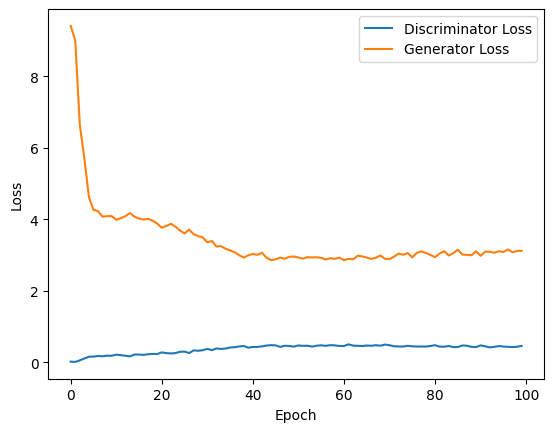

<Figure size 640x480 with 0 Axes>

In [16]:
plt.figure()
plt.plot(D_losses, label='Discriminator Loss')
plt.plot(G_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

if not os.path.exists('res'):
    os.makedirs('res')
plt.savefig('res/loss_MNIST_CNN.png', bbox_inches='tight')
plt.show()

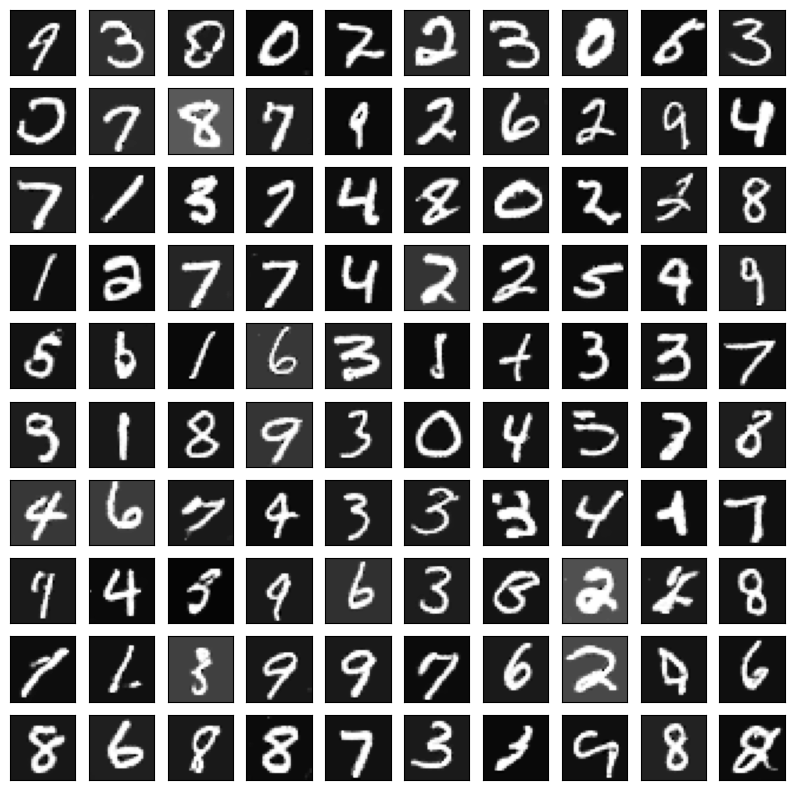

In [17]:
# Generate and plot final images
z = torch.Tensor(draw_sample(100, zdim)).view(-1, zdim, 1, 1).to(device)
G_sample_inf = G(z)
samples = G_sample_inf.detach().cpu().numpy()

# Plot the generated samples
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
for j, sample in enumerate(samples):
    ax = plt.subplot(gs[j])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(sample.squeeze(), cmap='Greys_r')

if not os.path.exists('res'):
    os.makedirs('res')
plt.savefig('res/final_generated_images_MNIST_CNN.png', bbox_inches='tight')
plt.show()

In [18]:
##load  Fashion - MNIST
Nsamples = 100
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=Nsamples,shuffle=True)

mnist_test = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=Nsamples, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 9947269.63it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 67909.62it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1485798.37it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9000532.30it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [19]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
zdim = 50
# Initialize models
G = Generator1x28x28(zdim).to(device)
D = Discriminator1x28x28().to(device)

# Optimizers
lr = 0.0002
G_opt = torch.optim.Adam(G.parameters(), lr=lr)
D_opt = torch.optim.Adam(D.parameters(), lr=lr)
# Generate samples
def draw_sample(m, n):
    return np.random.uniform(-1.0, 1.0, size=[m, n])

# Loss function
criterion = nn.BCELoss()
num_epochs = 100
# Samples
Nsamples = 100

# Lists to store losses
D_losses = []
G_losses = []

for epoch in range(num_epochs):
    D_loss_epoch = 0.0
    G_loss_epoch = 0.0
    num_batches = 0
    for imgs, _ in mnist_loader_train:
        imgs = imgs.to(device)
        batch_size = imgs.size(0)
        # Generate fake images
        z = torch.Tensor(draw_sample(batch_size, zdim)).view(-1, zdim, 1, 1).to(device)
        real_labels = torch.ones(Nsamples,1).to(device)
        fake_labels = torch.zeros(Nsamples,1).to(device)

        D_real_prob = D(imgs)
        G_sample = G(z)

        D_dake_prob = D(G_sample.detach())

        # 1. Update the discriminator using real and generated samples

        D_loss_real = criterion(D_real_prob, real_labels)
        D_loss_fake = criterion(D_dake_prob, fake_labels)
        D_loss = D_loss_real + D_loss_fake

        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()

        # 2. Update the generator

        G_fake_prob = D(G_sample)
        G_loss = criterion(G_fake_prob, real_labels)

        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()
        # Accumulate losses
        D_loss_epoch += D_loss.item()
        G_loss_epoch += G_loss.item()
        num_batches += 1

    # Calculate average losses for the epoch
    D_losses.append(D_loss_epoch / num_batches)
    G_losses.append(G_loss_epoch / num_batches)

    if epoch % 5 == 0:
        print('Epoch {}, Discriminator Loss {:.3f}, Generator Loss {:.3f}'.format(epoch, D_loss.item(), G_loss.item()))

Epoch 0, Discriminator Loss 0.001, Generator Loss 11.986


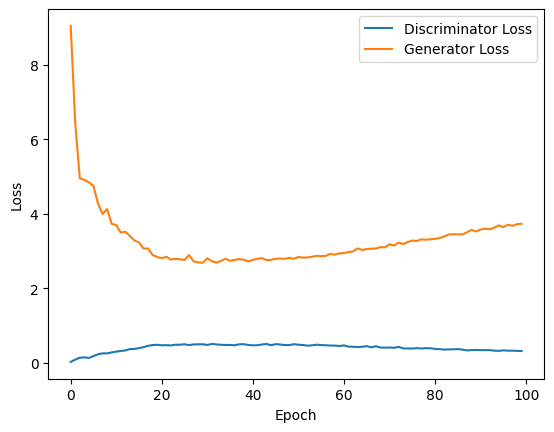

<Figure size 640x480 with 0 Axes>

In [20]:
plt.figure()
plt.plot(D_losses, label='Discriminator Loss')
plt.plot(G_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
if not os.path.exists('res'):
    os.makedirs('res')
plt.savefig('res/losses_FASHION_CNN.png', bbox_inches='tight')
plt.show()

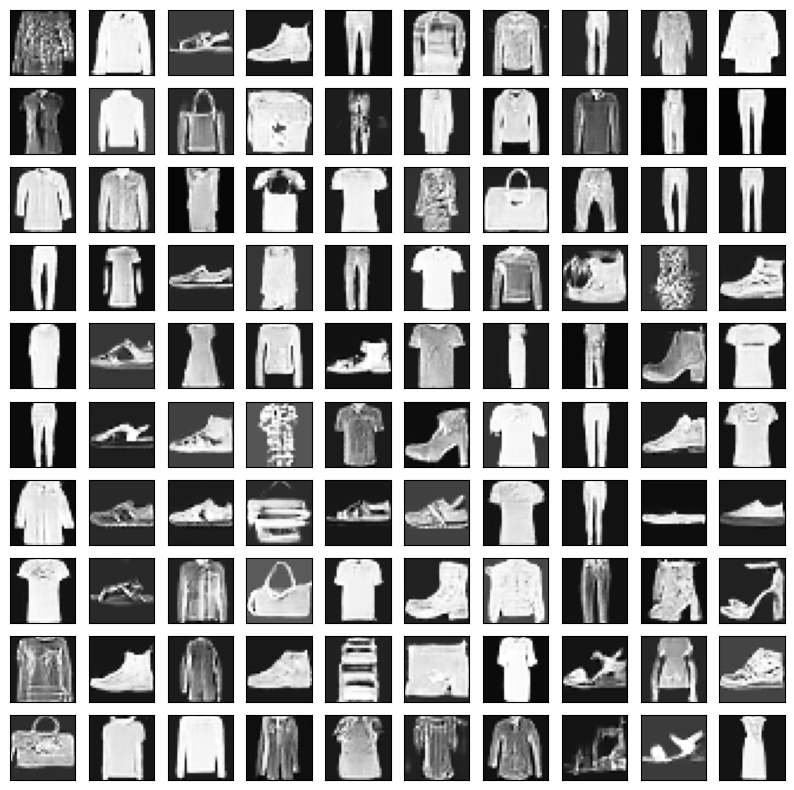

In [21]:
# Generate and plot final images
z = torch.Tensor(draw_sample(100, zdim)).view(-1, zdim, 1, 1).to(device)
G_sample_inf = G(z)
samples = G_sample_inf.detach().cpu().numpy()

# Plot the generated samples
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
for j, sample in enumerate(samples):
    ax = plt.subplot(gs[j])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(sample.squeeze(), cmap='Greys_r')

if not os.path.exists('res'):
    os.makedirs('res')
plt.savefig('res/final_generated_images_FASHION_CNN.png', bbox_inches='tight')
plt.show()

In [4]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + num_classes, 256, 7, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        c = self.label_emb(labels).view(labels.size(0), -1, 1, 1)
        x = torch.cat([noise, c], 1)
        x = self.model(x)
        return x

class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Conv2d(1 + num_classes, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        c = self.label_emb(labels).view(labels.size(0), -1, 1, 1)
        c = c.repeat(1, 1, img.size(2), img.size(3))
        x = torch.cat([img, c], 1)
        x = self.model(x)
        return x.view(-1, 1)  # Flatten the output


In [5]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
zdim = 50
num_classes = 10

# Initialize models
G = ConditionalGenerator(zdim, num_classes).to(device)
D = ConditionalDiscriminator(num_classes).to(device)

# Optimizers
lr = 0.0002
G_opt = torch.optim.Adam(G.parameters(), lr=lr)
D_opt = torch.optim.Adam(D.parameters(), lr=lr)

# Generate samples
def draw_sample(m, n):
    return np.random.uniform(-1.0, 1.0, size=[m, n])

# Loss function
criterion = nn.BCELoss()
num_epochs = 100

# Lists to store losses
D_losses = []
G_losses = []

for epoch in range(num_epochs):
    D_loss_epoch = 0.0
    G_loss_epoch = 0.0
    num_batches = 0
    for imgs, labels in mnist_loader_train:
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Generate fake images
        z = torch.Tensor(draw_sample(batch_size, zdim)).view(-1, zdim, 1, 1).to(device)
        G_sample = G(z, labels)

        # 1. Update the discriminator using real and generated samples
        D_real_prob = D(imgs, labels)
        D_fake_prob = D(G_sample.detach(), labels)

        D_loss_real = criterion(D_real_prob, real_labels)
        D_loss_fake = criterion(D_fake_prob, fake_labels)
        D_loss = D_loss_real + D_loss_fake

        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()

        # 2. Update the generator
        G_fake_prob = D(G_sample, labels)
        G_loss = criterion(G_fake_prob, real_labels)

        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()

        # Accumulate losses
        D_loss_epoch += D_loss.item()
        G_loss_epoch += G_loss.item()
        num_batches += 1

    # Calculate average losses for the epoch
    D_losses.append(D_loss_epoch / num_batches)
    G_losses.append(G_loss_epoch / num_batches)

    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Discriminator Loss {D_loss_epoch/num_batches:.3f}, Generator Loss {G_loss_epoch/num_batches:.3f}')

# To visualize and save samples after training, you can add code to generate images using the generator
# and then save or display them using a library like matplotlib.


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Discriminator Loss 0.142, Generator Loss 5.923
Epoch 5, Discriminator Loss 0.101, Generator Loss 5.363
Epoch 10, Discriminator Loss 0.155, Generator Loss 5.274
Epoch 15, Discriminator Loss 0.095, Generator Loss 5.520
Epoch 20, Discriminator Loss 0.094, Generator Loss 5.563
Epoch 25, Discriminator Loss 0.156, Generator Loss 4.769
Epoch 30, Discriminator Loss 0.090, Generator Loss 5.935
Epoch 35, Discriminator Loss 0.052, Generator Loss 6.393
Epoch 40, Discriminator Loss 0.034, Generator Loss 7.378
Epoch 45, Discriminator Loss 0.067, Generator Loss 6.614
Epoch 50, Discriminator Loss 0.220, Generator Loss 4.498
Epoch 55, Discriminator Loss 0.236, Generator Loss 3.766
Epoch 60, Discriminator Loss 0.313, Generator Loss 4.099
Epoch 65, Discriminator Loss 0.645, Generator Loss 2.259
Epoch 70, Discriminator Loss 0.784, Generator Loss 1.927
Epoch 75, Discriminator Loss 0.957, Generator Loss 1.690
Epoch 80, Discriminator Loss 0.969, Generator Loss 1.627
Epoch 85, Discriminator Loss 0.96

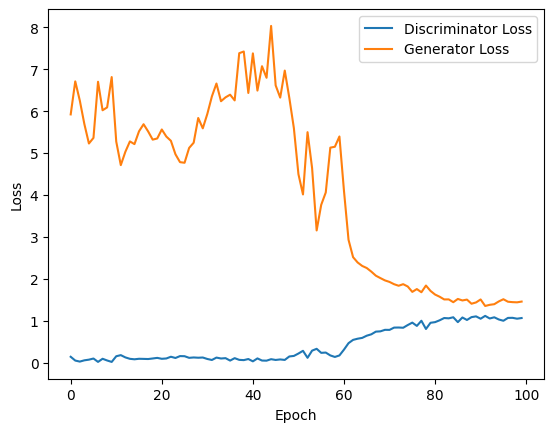

<Figure size 640x480 with 0 Axes>

In [8]:
import os

plt.figure()
plt.plot(D_losses, label='Discriminator Loss')
plt.plot(G_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
if not os.path.exists('res'):
    os.makedirs('res')
plt.savefig('res/losses_FASHION_CNN.png', bbox_inches='tight')
plt.show()

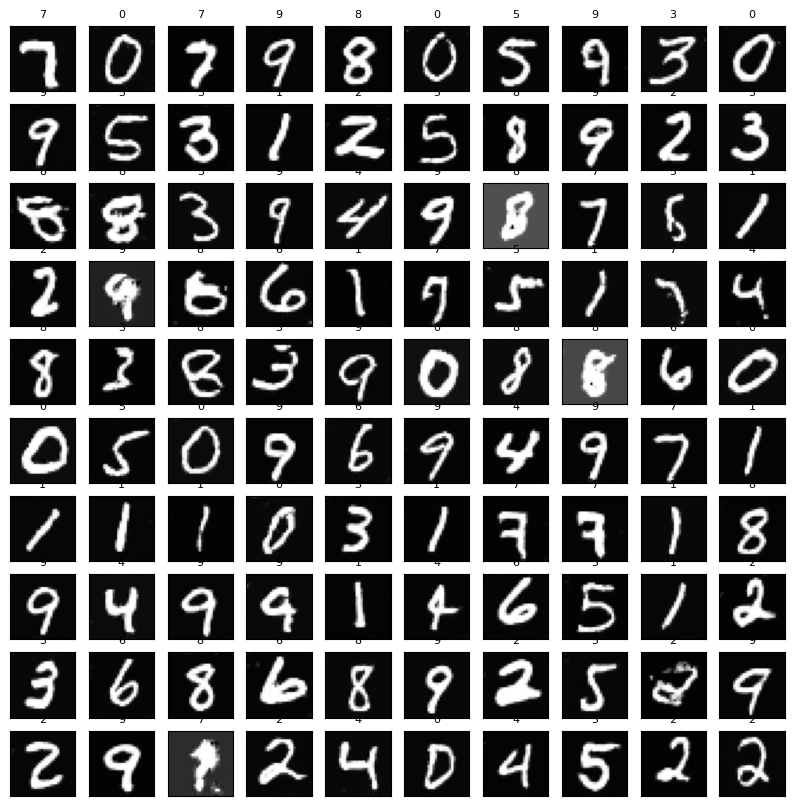

In [10]:
# Generate images using the generator
G_sample_inf = G(z, labels)
samples = G_sample_inf.detach().cpu().numpy()
labels = labels.cpu().numpy()

# Plot the generated samples with their corresponding labels
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
for j, (sample, label) in enumerate(zip(samples, labels)):
    ax = plt.subplot(gs[j])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(label), fontsize=8)
    plt.imshow(sample.squeeze(), cmap='Greys_r')

# Save the generated images
if not os.path.exists('res'):
    os.makedirs('res')
plt.savefig('res/final_generated_images_MNIST_CGAN.png', bbox_inches='tight')
plt.show()